![Save2Drive](https://raw.githubusercontent.com/alahnala/AI4All2020-Michigan-NLP/master/slides/save2drive.png)

# Make a copy of the [Documentation Template](https://docs.google.com/presentation/d/1zA1saxePvvjW_ZNA49L8U5Gh5yk6HmqHrcYjKokHcdQ/edit?usp=sharing) in your Drive for documentation

# Run the cell below to get setup

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  !rm -r AI4All2020-Michigan-NLP
  !git clone https://github.com/alahnala/AI4All2020-Michigan-NLP.git
  !cp -r AI4All2020-Michigan-NLP/utils/ .
  !cp -r AI4All2020-Michigan-NLP/Data/ .
  !cp -r AI4All2020-Michigan-NLP/slides/ .
  !cp -r AI4All2020-Michigan-NLP/Experiment-Report-Templates/ .
  !echo "=== Files Copied ==="
from utils.classification_helpers import *
import nltk
nltk.download('punkt')
from nltk.stem.snowball import PorterStemmer
from utils.nlp_basics import *
from utils.syllable import *


# general
from tqdm import tqdm
import os
import regex as re
from collections import Counter
import pandas as pd
import numpy as np


# preprocess functions
from nltk.tokenize import word_tokenize
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/allielahnala/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Determine if text is part of ingredients or procedure

There are so many recipes on the internet!! Wouldn't it be great if you could find new recipes based on your favorite ingredients or the ingredients you have available in your house? 

One challenge of this would be the fact that recipes posted on the internet can be formatted in very different ways. This could make information retrieval quite challenging.

In this part of the project, we will create a system that can tell us if a section of text belongs to a list of ingredients or a the cooking procedure.

# Data Observations

1. From utils.classification_helpers, we imported two data structures for you: `Ingredients` and `Procedures`
2. These are both lists of unstructure text from recipes obtained from wikipedia
3. Write some code in the cell below to help you get to understand what this data looks like.
4. Document your observations in the **Data Observations** slide. Keep in mind that you will be building a Decision Tree classifier, so try to specifically note some differences between the Ingredients text and the Procedures text. You can use these differences as “features” for your decision tree classifier.


In [2]:
'''
How long are our lists of Ingredients and Procedures?
'''
Ingredients_length = len(Ingredients)
Procedures_length = len(Procedures)
print("Length of Ingredients:", Ingredients_length, "Length of Procedure:", Procedures_length)

Length of Ingredients: 422 Length of Procedure: 422


In [3]:
'''
What does the text in Ingredients look like?
'''
import random
print(random.sample(Ingredients, k=2))
print(Ingredients[0])

['Potatoes - approximately 2 pounds (910\xa0g)\n2 teaspoons panch puran\nGround turmeric\nchili powder (preferably not too hot.  I use Kashmiri chili )\noil or, preferably, ghee', '1 kg flour, approx. 8 cups\n2 eggs\n200 g butter (or margarine), approx. 1 cup\n1 tsp. salt\n2-3 cups cold water\nolive oil\ncornstarch\nIngredients[edit]\n1 kg ground beef\n1 large onion\n2 tblsp vegetable oil\n2 tblsp sugar\n1 1/2 tsp black pepper\n1 1/2 tsp paprika\n1 tsp salt\n1/2 tsp ground cumin (comino), optional. Cumin is very invasive and gives the filling a whole different flavor.\n1/2 tsp ground cinnamon\n1/4 tsp nutmeg\n1/4 tsp cloves\n1/2 cup raisins\ngreen olives (optional)\ndiced hardboiled egg (optional)\ndiced boiled potatoes (optional)\nIngredients[edit]\n1 kg ground beef\n2 cloves garlic\n3 large onion\n2 tblsp olive oil\n1 tblsp sugar\n1 1/2 tsp black pepper\n1 1/2 tsp paprika\n1 tsp salt\n1/2 tsp ground cumin (comino)\n1 bay leaf\n1/2 cup raisins\nblack olives\ndiced hardboiled egg']
4 m

In [4]:
'''
What does the text in Procedures look like?
'''
import random
print(random.sample(Procedures, k=2))
print(Procedures[0])

['Boil salted water. Have ice water ready on the side. Poach shrimp for just 30 seconds and cool in ice water and drain.\nCombine with fish and toss with onion, ginger, garlic, hot pepper, celery, salt, and black pepper. Allow to cool in the refrigerator at least 30 minutes and up to 2 hours.\nAdd lemon and lime juices and refrigerate 1 additional hour. Finish with cilantro and corn, check seasoning.\nYield: 8 to 12 servings Prep Time: 2 hours\n\n\n\n\n\nWikipedia has related information at Ceviche\n\n', 'Mix the dates, sugar, and water in a saucepan.\nCook over low heat stirring constantly approx. 10 minutes or until thickened. Cool.\nCream together the butter, shortening, and brown sugar in a separate container.\nMix in the flour, salt, baking soda, and oats. (into the crumble crust mix, not the date filling)\nGrease a 13x9 pan.\nEvenly press ½ of the crumble mixture into the bottom of the pan.\nSpread the date filling on top.\nEvenly place remaining crumble mixture into the pan, pre

# Explore Data

- We created a function below called `make_histogram` which you can use to plot histograms of numerical data for the `Ingredients` and `Procedures` side-by-side to observe differences. Run the cell below to load the function.
- The following cell shows an example of using the function.


In [5]:
def make_histogram(List_of_Values_1, Title_1, X_label_1, List_of_Values_2, Title_2, X_label_2):
    %matplotlib inline
    import matplotlib
    import matplotlib.pyplot as plt
    import numpy as np

    matplotlib.rcParams.update({
        'font.family': 'serif',
        'font.size': 20
    })

    fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=False)


    n, bins, patches = axs[0].hist(x=List_of_Values_1, bins='auto', rwidth=0.9, color='#422e9e')

    axs[0].grid(axis='y', alpha=0.7, color='lavender')
    axs[0].set_xlabel(X_label_1)
    axs[0].set_ylabel('Frequency')
    axs[0].set_title(Title_1, pad=20)


    n, bins, patches = axs[1].hist(x=List_of_Values_2, bins='auto', rwidth=0.9, color='#422e9e')

    axs[1].grid(axis='y', alpha=0.7, color='lavender')
    axs[1].set_xlabel(X_label_2)
    axs[1].set_ylabel('Frequency')
    axs[1].set_title(Title_2, pad=20)

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(obj, collections.Iterator):
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


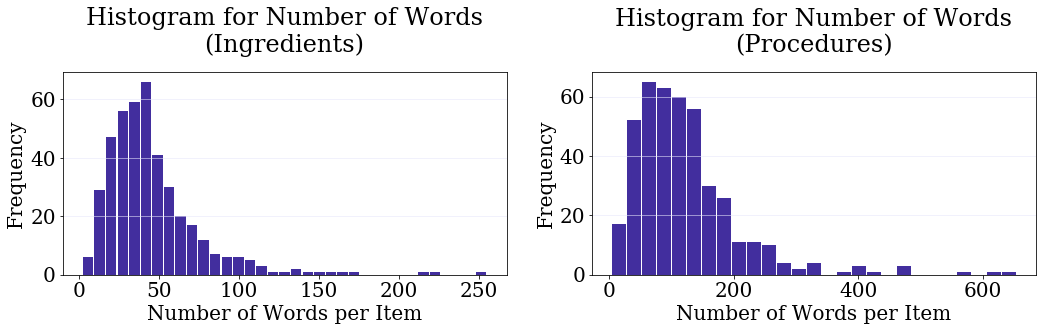

In [6]:
# List of numerical data for ingredients
Num_Words_Ingredients = [len(item.split()) for item in Ingredients]

# Load numerical data into List_of_Values and create a histogram title and X axis label
List_of_Values_1 = Num_Words_Ingredients
Title_1 = 'Histogram for Number of Words\n(Ingredients)'
X_label_1 = 'Number of Words per Item'

# List of numerical data for Procedures
Num_Words_Procedures = [len(item.split()) for item in Procedures]

# Load numerical data into List_of_Values and create a histogram title and X axis label
List_of_Values_2 = Num_Words_Procedures
Title_2 = 'Histogram for Number of Words\n(Procedures)'
X_label_2 = 'Number of Words per Item'

# Calls the make_histogram function to make histograms with the information we pass in
make_histogram(List_of_Values_1, Title_1, X_label_1, List_of_Values_2, Title_2, X_label_2)

## Use the cell below to make a list of a different numerical measure for each item in each list to plot in the histograms. Repeat for as many kinda of numeric data you like.

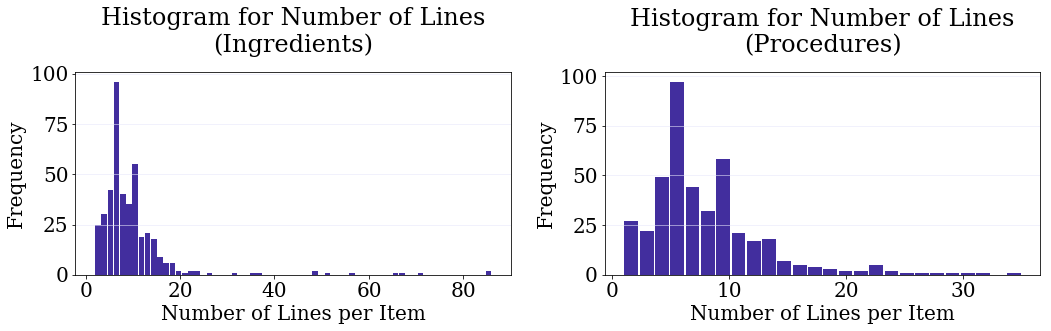

In [7]:
Num_Lines_Ingredients = [len(item.split('\n')) for item in Ingredients]
Num_Lines_Procedures = [len(item.split('\n')) for item in Procedures]

List_of_Values_1 = Num_Lines_Ingredients
Title_1 = 'Histogram for Number of Lines\n(Ingredients)'
X_label_1 = 'Number of Lines per Item'

List_of_Values_2 = Num_Lines_Procedures
Title_2 = 'Histogram for Number of Lines\n(Procedures)'
X_label_2 = 'Number of Lines per Item'
make_histogram(List_of_Values_1, Title_1, X_label_1, List_of_Values_2, Title_2, X_label_2)

## Documentation - paste your histograms in your slides, under the **Data Observations - Numerical** (create copies of the slide if you have multiple histograms).

# Simple Decision Tree

- Implement the function `simple_decision_tree` with one rule based on your data observations

In [9]:
def simple_decision_tree(item):
    num_words = len(item.split())
    if num_words > 60:
        decision = 'Procedure'
    else:
        decision = 'Ingredients'
    return decision

# Classify Ingredients

- Run the cell below to use you `simple_decision_tree` function on all of the ingredient items.
- The cell will count the number of correct decisions by your simple decision tree

In [10]:
# This for-loop will run the simple decision tree on each item of the Ingredients list 
ingredient_classifications = []
for item in Ingredients:
    decision = simple_decision_tree(item)
    ingredient_classifications.append(decision)
    
# Counter will count the number of times each unique item shows up in the list
ingredient_decision_counts = Counter(ingredient_classifications)

# This gets the number of times 'Ingredients' was decided
ingredients_correct = ingredient_decision_counts['Ingredients']

# Get the total number of items
total_ingredients = len(ingredient_classifications)

# Output the result
print("Number of Correct Decisions for Ingredients:", ingredients_correct, 'out of', total_ingredients)

Number of Correct Decisions for Ingredients: 335 out of 422


# Classify Procedures

- Run the cell below to use you `simple_decision_tree` function on all of the Procedures items.
- The cell will count the number of correct decisions by your simple decision tree

In [11]:
# This for-loop will run the simple decision tree on each item of the Procedures list 
procedure_classifications = []
for item in Procedures:
    decision = simple_decision_tree(item)
    procedure_classifications.append(decision)
    
# Counter will count the number of times each unique item shows up in the list
procedure_decision_counts = Counter(procedure_classifications)

# This gets the number of times 'Procedure' was decided
procedures_correct = procedure_decision_counts['Procedure']

# Get the total number of items
total_procedures = len(procedure_classifications)

# Output the result
print("Number of Correct Decisions for Procedures:", procedures_correct, 'out of', total_procedures)


Number of Correct Decisions for Procedures: 322 out of 422


# Output Simple Decision Tree Accuracy

In [20]:
def get_accuracy(actual, predicted):
    total_correct = len([1 for a,p in zip(actual, predicted) if a == p])
    total = len(actual)
    
    accuracy = total_correct / total
    return accuracy

actual = ['Ingredients'] * len(ingredient_classifications) + ['Procedure'] * len(procedure_classifications)
predicted = ingredient_classifications + procedure_classifications

accuracy = get_accuracy(actual, predicted)

print("Simple Decision Tree Accuracy: {:.2%}".format(accuracy))

Simple Decision Tree Accuracy: 77.84%


# Generate Confusion Matrix

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/local/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/local/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/local/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


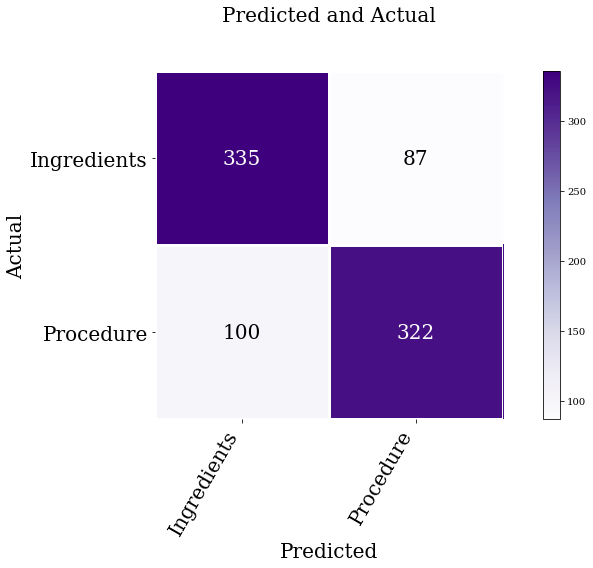

In [19]:
def actual_vs_predicted(actual, predicted):
    classes = Counter(actual).keys()
    co_occurrence_matrix =  np.zeros((len(classes), len(classes)))
    
    class_idx = {class_:i for i, class_ in enumerate(classes)}
    for actual_class, predicted_class in zip(actual, predicted):
        i = class_idx[actual_class]
        j = class_idx[predicted_class]
        co_occurrence_matrix[i][j] += 1

    co_occurrence_matrix = np.matrix(co_occurrence_matrix)


    make_heatmap(co_occurrence_matrix, rows=class_idx, cols=class_idx, annotate=True, xlabel='Predicted', ylabel='Actual', figsize=(12,8))

%matplotlib inline

actual_vs_predicted(actual, predicted)


## Generate text to help interpret confusion matrix

In [18]:
def actual_vs_predicted_text(actual, predicted):

    classes = Counter(actual).keys()
    co_occurrence_matrix =  np.zeros((len(classes), len(classes)))
    
    class_idx = {class_:i for i, class_ in enumerate(classes)}
    idx2class = {i:class_ for i, class_ in enumerate(classes)}
    
    for actual_class, predicted_class in zip(actual, predicted):
        i = class_idx[actual_class]
        j = class_idx[predicted_class]
        co_occurrence_matrix[i][j] += 1
    
    for class_1 in classes:
        for class_2 in classes:
            i = class_idx[class_1]
            j = class_idx[class_2]
            num = co_occurrence_matrix[i][j]
            print("{}\t{} items were classified as {}".format(int(num), class_1, class_2))

    return
actual_vs_predicted_text(actual, predicted)

335	Ingredients items were classified as Ingredients
87	Ingredients items were classified as Procedure
100	Procedure items were classified as Ingredients
322	Procedure items were classified as Procedure


# Preprocessing Data

- Write a function to preprocess the data into lists of tokens

In [8]:
def preprocess_line(text_line):
    
    text_line = text_line.split('\n')
    text_line = ' '.join(text_line)
    tokens = word_tokenize(text_line)
    
    return tokens

test_string = Ingredients[0]
print("Test string", test_string)
preprocessed_test_string = preprocess_line(test_string)
print("Test string preprocessed tokens", preprocessed_test_string)

Test string 4 medium-sized green mangoes
½ cup (120 mL) sugar
2 level tablespoons (30 mL) rock salt
1 level teaspoon (5 mL) roasted cumin seeds
1 roasted chili
A handful of fresh mint leaves
Test string preprocessed tokens ['4', 'medium-sized', 'green', 'mangoes', '½', 'cup', '(', '120', 'mL', ')', 'sugar', '2', 'level', 'tablespoons', '(', '30', 'mL', ')', 'rock', 'salt', '1', 'level', 'teaspoon', '(', '5', 'mL', ')', 'roasted', 'cumin', 'seeds', '1', 'roasted', 'chili', 'A', 'handful', 'of', 'fresh', 'mint', 'leaves']
